# Library and Inspect Data

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.utils import np_utils
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load data
df_train = pd.read_csv('/content/drive/MyDrive/Proa-ML/Demo/train.csv', sep=';')
df_test = pd.read_csv('/content/drive/MyDrive/Proa-ML/Demo/test.csv', sep=';')
print(len(df_train))
print(len(df_test))

45211
4521


In [ ]:
# Remove same data in df_train and df_test (to prevent leakage)
df_train = pd.concat([df_train, df_test])
df_train = df_train.drop_duplicates(keep=False)
df_train

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


# EDA

In [ ]:
def report(df):
    col = []
    d_type = []
    uniques = []
    n_uniques = []
    
    for i in df.columns:
        col.append(i)
        d_type.append(df[i].dtypes)
        uniques.append(df[i].unique()[:5])
        n_uniques.append(df[i].nunique())
    
    return pd.DataFrame({'Column': col, 'd_type': d_type, 'unique_sample': uniques, 'n_uniques': n_uniques})

report(df_train)

,Column,d_type,unique_sample,n_uniques
0,age,int64,"[58, 44, 33, 47, 35]",77
1,job,object,"[management, technician, entrepreneur, blue-co...",12
2,marital,object,"[married, single, divorced]",3
3,education,object,"[tertiary, secondary, unknown, primary]",4
4,default,object,"[no, yes]",2
5,balance,int64,"[2143, 29, 2, 1506, 1]",6877
6,housing,object,"[yes, no]",2
7,loan,object,"[no, yes]",2
8,contact,object,"[unknown, cellular, telephone]",3
9,day,int64,"[5, 6, 7, 8, 9]",31


In [ ]:
# Check percentage of null values per column
def color_null_red(val):
    color = 'red' if val > 0 else 'black'
    return 'color: %s' % color

pd.DataFrame(df_train.isna().sum()/len(df_train)*100, columns= ['%Null']).style.applymap(color_null_red, subset=['%Null'])

,%Null
age,0.000000
job,0.000000
marital,0.000000
education,0.000000
default,0.000000
balance,0.000000
housing,0.000000
loan,0.000000
contact,0.000000
day,0.000000


In [ ]:
# from pandas_profiling import ProfileReport
# profile = ProfileReport(df_train)

In [ ]:
# Create df for EDA
df_EDA = df_train.copy()

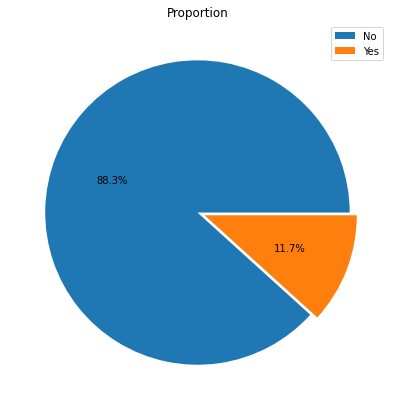

no     35922
yes     4768
Name: y, dtype: int64


In [ ]:
# Proportion of target
plt.rcParams['figure.figsize']=(7,7)
plt.pie(df_EDA['y'].value_counts(), explode = (0, 0.05), autopct='%1.1f%%')
plt.title('Proportion')
plt.legend(['No','Yes'])
plt.show()

print(df_EDA['y'].value_counts())

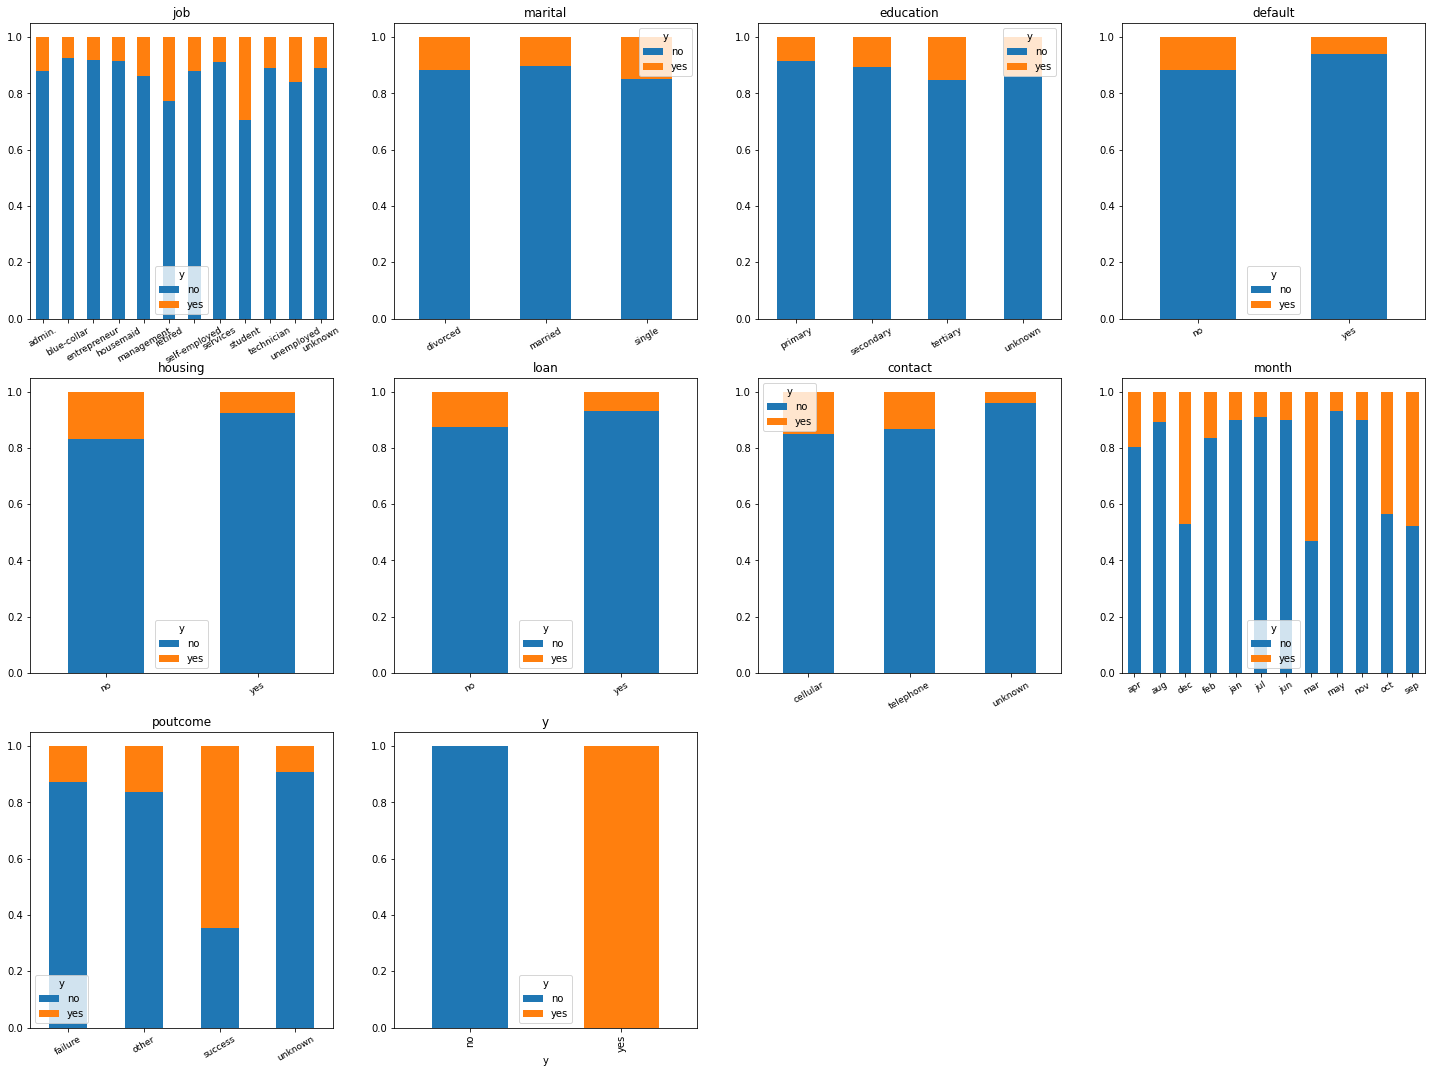

In [ ]:
# Visualize Categorical Features Cross Tabulation: Percentage Based on y value
cat_EDA = df_EDA.select_dtypes(include=['object']).columns.to_list()
a = 1

# plt.style.use('bmh')
for i in cat_EDA:
    plt.xlabel(None)
    plt.xticks(fontsize=9, rotation=30)
    axis = plt.subplot(4, 4, a)
    a += 1
    pd.crosstab(index=df_EDA[i], columns=df_EDA['y'], normalize=0).plot(kind='bar', stacked=True, ax=axis, figsize=(25,25))
    axis.title.set_text(i)   
plt.show();

In [ ]:
num_EDA = df_EDA.select_dtypes(include=['int64','float64']).columns.to_list()
num_EDA

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

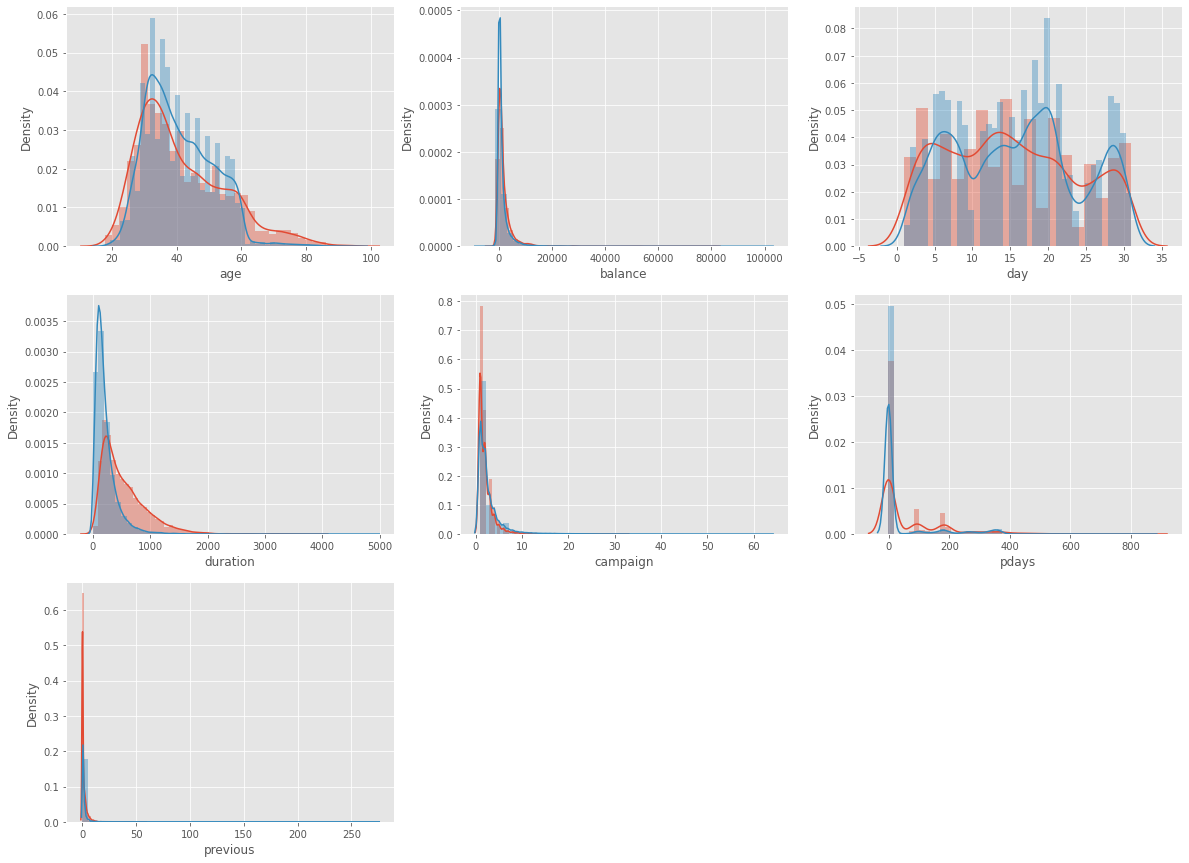

In [ ]:
# Visualize the distribution of numerical data
num_EDA = df_EDA.select_dtypes(include=['int64','float64']).columns.to_list()

plt.style.use('ggplot')
plt.figure(figsize = (20, 15))

for i in range(len(num_EDA)):
    plt.subplot(3, 3, i+1)
    sns.distplot(df_EDA[num_EDA[i]][df_EDA['y'] == 'yes'])
    sns.distplot(df_EDA[num_EDA[i]][df_EDA['y'] == 'no'])


# Preprocessing

In [ ]:
df_preprocessed = df_train.copy()

In [ ]:
# scaler = StandardScaler()

# def preprocess_func(data):
#   data[['age',	'balance',	'day',	'duration',	'campaign',	'pdays',	'previous']] = scaler.fit_transform(data.select_dtypes(include=['int64','float64']))
#   data = pd.get_dummies(data, columns=['job','month','loan','poutcome','contact','education',
#                                        'marital','default','housing'], drop_first=True)
  
#   return data

# # df_coba = preprocess_func(df_preprocessed)
# # df_coba

In [ ]:
# # define standard scaler
# scaler = StandardScaler()

# # transform data
# df_preprocessed[['age',	'balance',	'day',	'duration',	'campaign',	'pdays',	'previous']] = scaler.fit_transform(df_train.select_dtypes(include=['int64','float64']))
# df_preprocessed

In [ ]:
# # create dummy variables
# df_preprocessed = pd.get_dummies(df_preprocessed, columns=['job','month','loan','poutcome','contact','education',
#                                                            'marital','default','housing'], drop_first=True)
# df_preprocessed

In [ ]:
# # Create y
# label = df_preprocessed['y'].replace(['no', 'yes'],[0,1])
# y = np_utils.to_categorical(label, 2)
# y

In [ ]:
# X = df_preprocessed.drop(['y'], axis=1)
# X

In [ ]:
# # Split dataset
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=95, stratify=y)

In [ ]:
# # PRPEROCESS SMOTE
# df_preprocessed = preprocess_func(df_train)
# X = df_preprocessed.drop(['y'], axis=1)
# label = df_preprocessed['y'].replace(['no', 'yes'],[0,1])
# y = np_utils.to_categorical(label, 2)

# # Oversampling with SMOTE
# column_name = X.columns.to_list()
# column_name_y = 'y'
# column_name.append(column_name_y)

# smote = SMOTE()
# X_smo, y_smo = smote.fit_resample(X, y)
# smo_df = pd.DataFrame(pd.np.column_stack([X_smo, y_smo]))
# smo_df.columns = column_name

# X_ = smo_df.drop(['y'], axis=1)
# label = smo_df['y'].replace([0,1],[0,1])
# y_ = np_utils.to_categorical(label, 2)
# y_

# # Split dataset
# X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.1, random_state=95, stratify=y_)

In [ ]:
# Prepare variables for preprocessing
df_prepro = df_train.copy()
scaler = StandardScaler()

In [ ]:
# Preprocess
def age(dataframe):
    dataframe.loc[dataframe['age'] <= 32, 'age'] = 1
    dataframe.loc[(dataframe['age'] > 32) & (dataframe['age'] <= 39), 'age'] = 2
    dataframe.loc[(dataframe['age'] > 39) & (dataframe['age'] <= 48), 'age'] = 3
    dataframe.loc[(dataframe['age'] > 48) & (dataframe['age'] <= 70), 'age'] = 4
    dataframe.loc[(dataframe['age'] > 70) & (dataframe['age'] <= 98), 'age'] = 5

def pdays(dataframe):
    dataframe.loc[dataframe['pdays'] == -1, 'pdays'] = 1
    dataframe.loc[(dataframe['pdays'] >= 0) & (dataframe['pdays'] <= 133), 'pdays'] = 2
    dataframe.loc[(dataframe['pdays'] > 133) & (dataframe['pdays'] <= 194), 'pdays'] = 3
    dataframe.loc[(dataframe['pdays'] > 194) & (dataframe['pdays'] <= 327), 'pdays'] = 4
    dataframe.loc[dataframe['pdays'] > 327, 'pdays'] = 5

def previous(dataframe):
    dataframe.loc[dataframe['previous'] == 0, 'previous'] = 1
    dataframe.loc[dataframe['previous'] == 1, 'previous'] = 2
    dataframe.loc[dataframe['previous'] == 2, 'previous'] = 3
    dataframe.loc[(dataframe['previous'] > 2) & (dataframe['previous'] <= 4), 'previous'] = 4
    dataframe.loc[dataframe['previous'] > 4, 'previous'] = 5

def jobtoint(df):
  df['job'].replace(['management', 'technician', 'entrepreneur', 'blue-collar',
       'unknown', 'retired', 'admin.', 'services', 'self-employed',
       'unemployed', 'housemaid', 'student'] , [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], inplace=True)
  
def monthtoint(df):
  df['month'].replace(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec', ] , 
                      [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], inplace=True)
  
def preprocess_int(df):
  df[['balance', 'duration', 'campaign']] = scaler.fit_transform(df[['balance', 'duration', 'campaign']]) 
  # df['duration'] = scaler.fit_transform(df['duration'])
  # df['campaign'] = scaler.fit_transform(df['campaign'])
  age(df)
  pdays(df)
  previous(df)
  jobtoint(df)
  monthtoint(df)

preprocess_int(df_prepro)

# # Oversampling
# a = df_prepro[df_prepro["y"] == "yes"].shape
# b = df_prepro[df_prepro["y"] == "no"].shape
# while b[0]/a[0] > 1.2:
#   df_random = df_prepro[df_prepro["y"] == "yes"].sample(frac=0.5)
#   df_train = pd.concat([df_prepro, df_random])
#   a = df_prepro[df_prepro["y"] == "yes"].shape

# df_prepro.reset_index(drop=True, inplace=True)
# a = df_prepro[df_prepro["y"] == "yes"].shape

# One hot
df_prep = pd.get_dummies(df_prepro, columns=['job','loan','poutcome','contact','education',
                                            'marital','default','housing','pdays','previous'], drop_first=True)

# df_preprocessed = preprocess_func(df_train)
X = df_prep.drop(['y', 'duration'], axis=1)
label = df_prep['y'].replace(['no', 'yes'],[0,1])
y = np_utils.to_categorical(label, 2)

# Oversampling with SMOTE
column_name = X.columns.to_list()
column_name_y = 'y'
column_name.append(column_name_y)

smote = SMOTE()
X_smo, y_smo = smote.fit_resample(X, y)
smo_df = pd.DataFrame(pd.np.column_stack([X_smo, y_smo]))
smo_df.columns = column_name

# Make X and y
X = smo_df.drop(['y'], axis=1)
label = smo_df['y'].replace([0,1],[0,1])
y = np_utils.to_categorical(label, 2)
y

# Split
size = X.shape[1]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=85, stratify=y)

In [ ]:
X

,age,balance,day,month,campaign,job_2,job_3,job_4,job_5,job_6,...,education_tertiary,education_unknown,marital_married,marital_single,default_yes,housing_yes,pdays_3,pdays_4,pdays_5,previous_5
0,4.0,0.258297,5.0,5.0,-0.568520,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,3.0,-0.435143,5.0,5.0,-0.568520,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2.0,-0.443999,5.0,5.0,-0.568520,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3.0,0.049347,5.0,5.0,-0.568520,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2.0,-0.444327,5.0,5.0,-0.568520,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71839,3.0,-0.368996,20.0,4.0,-0.343094,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
71840,2.0,-0.313062,3.0,8.0,-0.568520,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
71841,1.0,-0.464062,18.0,6.0,-0.213774,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
71842,4.0,0.250708,30.0,4.0,-0.568520,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modeling

## Training

In [ ]:
# Build model
size = X.shape[1]

model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(size,)),
        tf.keras.layers.Dense(64, activation='relu'),
        BatchNormalization(), 
        tf.keras.layers.Dense(128, activation='relu'),
        BatchNormalization(),                           
        tf.keras.layers.Dense(256, activation='relu'),
        BatchNormalization(), 
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(2, activation=tf.nn.sigmoid)])

In [ ]:
# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                2176      
                                                                 
 batch_normalization_3 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 128)               8320      
                                                                 
 batch_normalization_4 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 256)               33024     
                                                                 
 batch_normalization_5 (Batc  (None, 256)             

In [ ]:
# Compile model
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Set callback
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if (logs.get('accuracy')>.96):
            self.model.stop_training=True

earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, restore_best_weights=True)

callback = [earlystop, myCallback()]

In [ ]:
# # Our vectorized labels
# y_train = np.asarray(train_labels).astype('float32').reshape((-1,1))
# y_test = np.asarray(test_labels).astype('float32').reshape((-1,1))

In [ ]:
# Fit model
history = model.fit(X_train, y_train,
                   validation_data=(X_val, y_val),
                   epochs=300, batch_size=100, verbose=1)

print('History of the training', history.history)

Epoch 1/300
647/647 [==============================] - 6s 7ms/step - loss: 0.4501 - accuracy: 0.7913 - val_loss: 0.3929 - val_accuracy: 0.8246
Epoch 2/300
647/647 [==============================] - 5s 7ms/step - loss: 0.3992 - accuracy: 0.8225 - val_loss: 0.3865 - val_accuracy: 0.8310
Epoch 3/300
647/647 [==============================] - 4s 7ms/step - loss: 0.3825 - accuracy: 0.8315 - val_loss: 0.3766 - val_accuracy: 0.8370
Epoch 4/300
647/647 [==============================] - 4s 7ms/step - loss: 0.3716 - accuracy: 0.8378 - val_loss: 0.3629 - val_accuracy: 0.8440
Epoch 5/300
647/647 [==============================] - 4s 7ms/step - loss: 0.3635 - accuracy: 0.8422 - val_loss: 0.3576 - val_accuracy: 0.8438
Epoch 6/300
647/647 [==============================] - 5s 7ms/step - loss: 0.3556 - accuracy: 0.8468 - val_loss: 0.3479 - val_accuracy: 0.8515
Epoch 7/300
647/647 [==============================] - 4s 7ms/step - loss: 0.3464 - accuracy: 0.8507 - val_loss: 0.3448 - val_accuracy: 0.8525

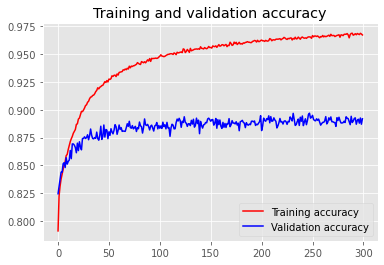

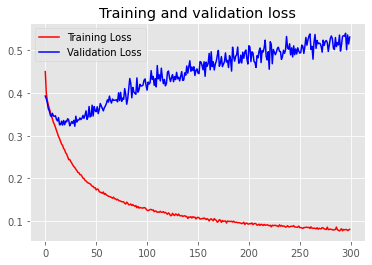

In [ ]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Predict
y_predict = model.predict(X_val)
ypred = np.argmax(y_predict, axis=1)
ytes = np.argmax(y_val, axis=1)

In [ ]:
# Confusion matrix
confusion_matrix(ytes, ypred)

array([[3099,  493],
       [ 284, 3309]])

In [ ]:
# Classification Report
print(classification_report(ytes, ypred))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89      3592
           1       0.87      0.92      0.89      3593

    accuracy                           0.89      7185
   macro avg       0.89      0.89      0.89      7185
weighted avg       0.89      0.89      0.89      7185



## Testing

In [ ]:
df_test

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
# df_test_preprocessed = preprocess_func(df_test)
# df_test_preprocessed

In [ ]:
# labels = df_test_preprocessed['y'].replace(['no', 'yes'],[0,1])
# Y = np_utils.to_categorical(labels, 2)
# Y

In [ ]:
# X_test = df_test_preprocessed.drop(['y'], axis=1)
# X_test

In [ ]:
preprocess_int(df_test)
dftestdum = pd.get_dummies(df_test, columns=['job','loan','poutcome','contact','education','marital',
                                             'default','housing','pdays','previous'], drop_first=True)
labels = dftestdum['y'].replace(['no', 'yes'],[0,1])
Y = np_utils.to_categorical(labels, 2)
X_test = dftestdum.drop(['y','duration'], axis=1)
X_test


,age,balance,day,month,campaign,job_2,job_3,job_4,job_5,job_6,...,education_tertiary,education_unknown,marital_married,marital_single,default_yes,housing_yes,pdays_3,pdays_4,pdays_5,previous_5
0,1,0.121072,19,10,-0.576829,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,2,1.118644,11,5,-0.576829,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
2,2,-0.024144,16,4,-0.576829,0,0,0,0,0,...,1,0,0,1,0,1,0,0,1,0
3,1,0.017726,3,6,0.387967,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0
4,4,-0.472753,5,5,-0.576829,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,2,-0.583410,30,7,0.709566,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
4517,4,-1.573671,9,5,-0.576829,0,0,0,0,0,...,1,0,1,0,1,1,0,0,0,0
4518,4,-0.374724,19,8,2.639160,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4519,1,-0.094925,6,2,0.387967,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0


In [ ]:
Y_predict = model.predict(X_test)
Ypred = np.argmax(Y_predict, axis=1)
Ytes = np.argmax(Y, axis=1)

In [ ]:
confusion_matrix(Ytes, Ypred)

array([[3463,  537],
       [ 327,  194]])

In [ ]:
print(classification_report(Ytes, Ypred))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      4000
           1       0.27      0.37      0.31       521

    accuracy                           0.81      4521
   macro avg       0.59      0.62      0.60      4521
weighted avg       0.84      0.81      0.82      4521

